## Load preprocessed data

In [ ]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder

# I need to put this because i noticed that even though i set the parameters same from 1st and 2nd training, 
# the results are different
# This is to make the results reproducible
MODEL_VERSION = '19'
batch_size = 4
SEED = 32

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


class VideoDataGenerator(Sequence):
    def __init__(self, folder_path, class_labels, batch_size, shuffle=True, encoder=None, seed=32):
        self.folder_path = folder_path
        self.class_labels = class_labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.encoder = encoder or LabelEncoder()
        self.rng = np.random.default_rng(seed)
        self.video_paths, self.labels = self._load_paths_and_labels()
        self.on_epoch_end()

    def _load_paths_and_labels(self):
        video_paths, labels = [], []
        for class_name in self.class_labels:
            class_folder = os.path.join(self.folder_path, class_name)
            for file in os.listdir(class_folder):
                video_paths.append(os.path.join(class_folder, file))
                labels.append(class_name)
        return video_paths, labels

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.video_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_data = []
        for path in batch_paths:
            video = np.load(path) / 255.0  # Normalize
            batch_data.append(video)

        batch_data = np.array(batch_data)
        batch_labels = self.encoder.transform(batch_labels)
        batch_labels = to_categorical(batch_labels, num_classes=len(self.class_labels))

        return batch_data, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.video_paths, self.labels))
            self.rng.shuffle(temp)
            self.video_paths, self.labels = zip(*temp)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = 216
FRAMES = 20
CHANNELS = 3
CLASSES = ['Suspicious', 'Non-suspicious']

def build_3d_cnn(input_shape=(FRAMES, IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)

    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)

    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    
    # Choose optimizer
    # Option 1: Adam
    optimizer = Adam(learning_rate=0.0004)

    # optimizer = SGD(learning_rate=0.01, momentum=0.9)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Initialize and train the model
model = build_3d_cnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 216, 216,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 20, 216, 216,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 216, 216,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 108, 108,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 108, 108,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 108, 108,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 54, 54, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 54, 54, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 54, 54, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 27, 27, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,056,706 (183.32 MB)

 Trainable params: 48,056,258 (183.32 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
CLASSES = ['Suspicious', 'Non-suspicious']


# Initialize label encoder
encoder = LabelEncoder()
encoder.fit(CLASSES)

# Create data generators
train_gen = VideoDataGenerator("dataset.npy/Train", CLASSES, batch_size=batch_size, encoder=encoder, seed=SEED)
val_gen = VideoDataGenerator("dataset.npy/Val", CLASSES, batch_size=batch_size, encoder=encoder, seed=SEED)
test_gen = VideoDataGenerator("dataset.npy/Test", CLASSES, batch_size=batch_size, encoder=encoder, seed=SEED, shuffle=False)


In [ ]:
import tensorflow as tf

model_name = f"examination_behavior-{FRAMES}F-{IMG_SIZE}IS-{MODEL_VERSION}.keras"

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=100,
                    callbacks=[early_stop, lr_scheduler],
                    shuffle=False)

# Save the trained model
model.save(model_name)

# Append model summary to a markdown file
with open("model_summary.md", "a") as f:
    f.write(f"## Model Name: {model_name}\n")
    model.summary(print_fn=lambda x: f.write(x + '\n'))

c:\Users\Raymond\Desktop\3D-CNN\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4781 - loss: 26.3965

c:\Users\Raymond\Desktop\3D-CNN\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.4789 - loss: 26.2590 - val_accuracy: 0.5000 - val_loss: 1.2437 - learning_rate: 4.0000e-04
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.5703 - loss: 8.4476 - val_accuracy: 0.5000 - val_loss: 1.5236 - learning_rate: 4.0000e-04
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.5964 - loss: 1.4738 - val_accuracy: 0.5000 - val_loss: 1.3865 - learning_rate: 4.0000e-04
Epoch 4/100
 8/29 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.7074 - loss: 0.6997

c:\Users\Raymond\Desktop\3D-CNN\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 75.00%

Classification Report:
                precision    recall  f1-score   support

    Suspicious       0.85      0.61      0.71        18
Non-suspicious       0.70      0.89      0.78        18

      accuracy                           0.75        36
     macro avg       0.77      0.75      0.75        36
  weighted avg       0.77      0.75      0.75        36



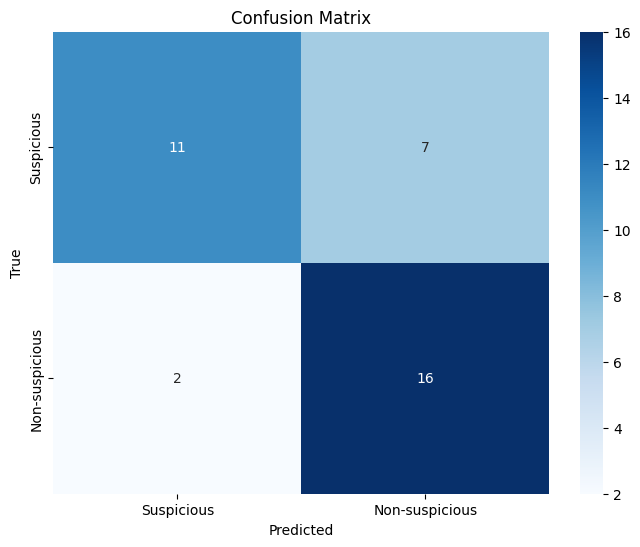

In [8]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the model if needed
model = tf.keras.models.load_model("examination_behavior-20F-216IS-16.keras")
# model = tf.keras.models.load_model(model_name)


# Evaluate
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

def get_all_true_labels(generator):
    all_labels = []
    for i in range(len(generator)):
        _, labels = generator[i]
        all_labels.extend(np.argmax(labels, axis=1))
    return np.array(all_labels)


# Get true labels from test generator
y_true = get_all_true_labels(test_gen)

# Predict with the model
y_pred_probs = model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
report_str = classification_report(y_true, y_pred, target_names=CLASSES)
print("\nClassification Report:")
print(report_str)

kappa = cohen_kappa_score(y_true, y_pred)
# print(f"\nCohen's Kappa Score: {kappa:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

with open("model_summary.md", "a") as f:
    f.write("## Model Evaluation Results\n\n")
    f.write(f"**Test Accuracy**: {test_acc * 100:.2f}%\n\n")
    f.write("### Classification Report\n```\n")
    f.write(report_str)
    f.write("```\n\n")
    f.write("### Confusion Matrix\n")
    f.write(conf_matrix_df.to_markdown(index=False))
    f.write("\n\n")



In [4]:
import tensorflow as tf

model = tf.keras.models.load_model("examination_behavior-20F-216IS-16.keras")

model.summary()

with open("model_summary.md", "a", encoding="utf-8") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 216, 216,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 20, 216, 216,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 216, 216,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 108, 108,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 108, 108,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 108, 108,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 54, 54, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 54, 54, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 54, 54, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 27, 27, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,169,224 (549.96 MB)

 Trainable params: 48,056,258 (183.32 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 96,112,518 (366.64 MB)